In [1]:
import sys; sys.path.insert(0, '..')

import gym
import sys
import torch
import tester
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

import pytorch_drl.models.ppo_models as models
import pytorch_drl.models.gail_models as gail_models

from pytorch_drl.algs.gail import GAIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


## 1. Define Utils:

### 1.1 Plotting:

In [3]:
def mean_filter(arr, filter_len):
    arr = np.concatenate([[0]*(filter_len-1), arr])
    filter_arr = np.ones(filter_len)/filter_len
    arr = arr
    output = list()
    for i in range(filter_len-1, len(arr)):
        conv = np.sum(filter_arr * arr[i-filter_len+1:i+1])
        output.append(conv)
    return output

def plot(scores, n=None):
    if n is not None:
        scores = mean_filter(scores, n)
    clear_output(True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

## 2. Create environment

In [4]:
env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)

state_size =  env.observation_space.shape[0]
action_size = env.action_space.n

print("State size:", state_size, "\nAction size:", action_size)

/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State size: 4 
Action size: 2


## 4. GAIL Test

In [5]:
expert_trajectories = np.load("experts/ppo_{}".format(env_name))

In [6]:
print(expert_trajectories.shape)

(300000, 6)


AVG score is 195.12, i: 763                    Solved! Episode 0


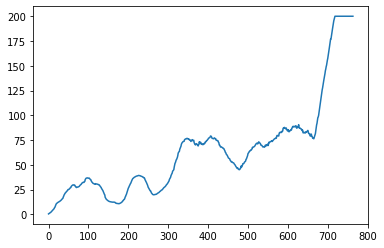

Process Process-15:
Process Process-17:
Process Process-14:
Process Process-16:
Process Process-13:
Process Process-18:
Process Process-12:
Process Process-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/selo/anaconda3/envs/ml-agents/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/selo/anaconda3/envs/ml-agents/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/selo/anaconda3/envs/ml-agents/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/selo/anaconda3/envs/ml-agents/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/selo/anaconda3/envs

In [9]:
ppo_net_constr = models.PPOPolicyNetwork
ppo_net_args = (state_size, action_size)

discriminator_constr = gail_models.GAILDiscriminator
discriminator_args = (state_size, action_size)

tmax = 5
n_traj = 2000
n_env = 8
ppo_epochs = 4
batch_size = 32

# init agent:
agent = GAIL(ppo_net_constr,
             ppo_net_args,
             discriminator_constr,
             discriminator_args,
             expert_trajectories,
             env_name,
             action_size,
             gamma=0.99, 
             gail_epochs=1,
             ppo_epochs=ppo_epochs,
             lr_ppo=3e-3, 
             lr_discriminator=3e-3,
             tau=0.95,
             n_env=n_env,
             device=device,
             max_grad_norm=0.5,
             critic_coef=0.5,
             entropy_coef=0.01,
             mini_batch_size=batch_size,
             )
   
    
# train the agent
scores, losses = agent.train(tmax, n_traj,  env)

# plot the training:
x = np.arange(len(scores))
scores = mean_filter(scores, 50)
plt.plot(x, scores, label = "scores")
plt.show()

### 4.1 Trained Agent Demonstration

In [14]:
agent.test(env, render=True, n_times=5)

200.0
200.0
200.0
200.0
200.0


## 5. GAIL Continuous Test
